In [1]:
import pandas as pd
import json
import sys
import os
from nltk.translate.bleu_score import corpus_bleu,sentence_bleu
from rouge import Rouge
from sentence_transformers import SentenceTransformer, util
sys.setrecursionlimit(2000)
import warnings
warnings.filterwarnings("ignore")


class DatasizeError(Exception):
    def __init__(self, message) :
        super().__init__(message)
        self.message=message

class SampleError(Exception):
    def __init__(self, message) :
        super().__init__(message)
        self.message=message

class CaseidError(Exception):
    def __init__(self, message) :
        super().__init__(message)
        self.message=message

error_msg={
    1: "Wrong data size",
    2: "Wrong sample format",
    3: "Wrong case id"
}

def dump_2_json(info, path):
    with open(path, 'w') as output_json_file:
        json.dump(info, output_json_file)

def report_error_msg(detail, showMsg, out_p):
    error_dict=dict()
    error_dict['errorDetail']=detail
    error_dict['errorMsg']=showMsg
    error_dict['score']=0
    error_dict['scoreJson']={}
    error_dict['success']=False
    dump_2_json(error_dict,out_p)

def report_score(score, out_p):
    result = dict()
    result['success']=True
    total_score = score['Edit_acc']['final_score'] * 0.2 + score['portability']['final_score'] * 0.35 + score['locality']['final_score']  * 0.35 + score['fluency'] * 0.1
    result['score'] = total_score
    result['scoreJson'] = {'score': total_score, 
                           'Edit_acc':score['Edit_acc']['final_score'], 
                           'Edit_acc2':score['Edit_acc2']['final_score'],
                           'portability':score['portability']['final_score'], 
                           'portability2':score['portability2']['final_score'], 
                           'locality':score['locality']['final_score'], 
                           'locality2':score['locality2']['final_score'], 
                           'fluency':score['fluency']}
    # print(result['scoreJson'])
    dump_2_json(result,out_p)
    return result

def sample_format(sample_list):
    tag=True
    for x in sample_list:                                                          
        list1 = x.keys()
        # list2 = x['pre'].keys()
        list3 = x['requested_rewrite'].keys()
        list4 = x['post'].keys()
        # if(list(list1)!=['pre', 'case_id', 'requested_rewrite', 'post']):
        if(list(list1)!=['case_id', 'requested_rewrite', 'post']):
            tag=False
            break
        # elif(list(list2)!=['rewrite_ans','rephrase_ans','portability_ans'] and list(list2)!=['rewrite_ans','rephrase_ans','locality_ans','portability_ans']):
        #     tag=False
        #     break
        elif('target_new' not in list3 or 'portability' not in list3 or 'locality' not in list3):
            tag=False
            break
        # fluency_new
        # elif(list(list4)!=['rewrite_ans','rephrase_ans','locality_ans','portability_ans','fluency', 'fluency_new'] and \
        #       list(list4)!=['rewrite_ans','rephrase_ans','portability_ans','fluency', 'fluency_new']) or \
        #       (list(list4)!=['rewrite_ans','rephrase_ans','locality_ans','portability_ans','fluency'] and \
        #       list(list4)!=['rewrite_ans','rephrase_ans','portability_ans','fluency']):
        #     tag=False
        #     break  
    return tag

def test_case_id(sample_list):
    tag =True
    for x in range(len(sample_list)-1):
        if(sample_list[x+1]['case_id']!=sample_list[x]['case_id']+1):
            tag = False
            break
    return tag

def check_format(submit_p):
    with open(submit_p, 'r',encoding='utf-8') as file:
        if 'log' in submit_p:
            lines = file.readlines()
            submit_file = []
            for line in lines:
                submit_file.append(json.loads(line))
        else:
            submit_file=json.load(file)
    # if len(submit_file)!=700:
    #     raise DatasizeError("Wrong data size")
    if (not sample_format(submit_file)):
        raise SampleError("Wrong sample format")
    # if (not test_case_id(submit_file)):
    #     raise CaseidError("Wrong case id")

def compute_acc(answers,outputs):
    # model_path = './paraphrase-multilingual-MiniLM-L12-v2'
    model_path = '/share/huggingface/paraphrase-multilingual-MiniLM-L12-v2'
    bleu_scores = []
    rouge1s=[]
    rouge2s=[]
    rougels=[]
    rouge = Rouge()
    for an,ou in zip(answers,outputs):
        score = sentence_bleu([an], ou)
        bleu_scores.append(score)
        scores = rouge.get_scores(ou,an)
        rouge1s.append(scores[0]['rouge-1']['r'])
        rouge2s.append(scores[0]['rouge-2']['r'])
        rougels.append(scores[0]['rouge-l']['r'])

    temp_metrics = {}
    temp_metrics['BLEU SCORE'] = sum(bleu_scores) / len(bleu_scores)
    temp_metrics['ROUGE-1'] = sum(rouge1s) / len(rouge1s)
    temp_metrics['ROUGE-2'] = sum(rouge2s) / len(rouge2s)
    temp_metrics['ROUGE-L'] = sum(rougels) / len(rougels)

    model = SentenceTransformer(model_path, device="cpu")

    embeddings1 = model.encode(answers, convert_to_tensor=True)
    embeddings2 = model.encode(outputs, convert_to_tensor=True)

    # Compute cosine-similarities
    cosine_scores = util.cos_sim(embeddings1, embeddings2)
    temp_metrics['Bert Score'] = cosine_scores.diagonal().mean().item()
    temp_metrics['final_score'] = (temp_metrics['ROUGE-L']+temp_metrics['Bert Score'])/2
    temp_metrics['final_score'] = temp_metrics['final_score']*100
    
    return temp_metrics

def eval_score(result_path):
    with open(result_path, 'r', encoding='utf-8') as file:
        if 'log' in result_path:
            lines = file.readlines()
            print(f'data size: {len(lines)}')
            data = []
            for line in lines:
                data.append(json.loads(line))
        else:
            data=json.load(file)
    metrics = {}

    #evaluate Edit_acc
    # rewrite_answer = [i['requested_rewrite']['target_new'] for i in data]
    # rewrite_outputs = [i['post']['rewrite_ans'] for i in data]
    rewrite_answer, rewrite_outputs, rewrite_outputs2 = [], [], []
    for item in data:
        rewrite_answer.append(item['requested_rewrite']['target_new'])
        rewrite_outputs.append(item['post']['rewrite_ans'])
        rewrite_outputs2.append(item['post']['rewrite_ans'][:len(rewrite_answer[-1])+1])

    metrics['Edit_acc'] = compute_acc(rewrite_answer,rewrite_outputs)
    metrics['Edit_acc2'] = compute_acc(rewrite_answer,rewrite_outputs2)

    #evaluate portability
    portability_answer = []
    portability_outputs = []
    portability_outputs2 = []
    for item in data:
        for an in item['requested_rewrite']['portability']['por_hop']['ground_truth']:
            portability_answer.append(an)
        for ou in item['post']['portability_ans']:
            portability_outputs.append(ou)
        for idx, ou in enumerate(item['post']['portability_ans']):
            portability_outputs2.append(ou[:len(portability_answer[idx])+1])
    metrics['portability'] = compute_acc(portability_answer,portability_outputs)
    metrics['portability2'] = compute_acc(portability_answer,portability_outputs2)

    #evaluate locality
    locality_answer = []
    locality_outputs = []
    locality_outputs2 = []
    for item in data:
        if ('locality_ans' not in item['post'].keys() or len(item['requested_rewrite']['locality']['loc_hop']['prompt'])==0):
            continue
        for an in item['requested_rewrite']['locality']['loc_hop']['ground_truth']:
            locality_answer.append(an)
        for ou in item['post']['locality_ans']:
            locality_outputs.append(ou)
        for idx, ou in enumerate(item['post']['locality_ans']):
            locality_outputs2.append(ou[:len(locality_answer[idx])+1])
    if len(locality_answer)!=0 and len(locality_outputs)!=0:
        metrics['locality'] = compute_acc(locality_answer,locality_outputs)
        metrics['locality2'] = compute_acc(locality_answer,locality_outputs2)
    else:
        metrics['locality'] = {'final_score': 0}

     #evaluate fluency
    fluencys = [i['post']['fluency']['ngram_entropy'] for i in data]
    metrics['fluency'] = sum(fluencys) / len(fluencys) *10

    return metrics

In [2]:
type = 'type5_70'
root_dir = f'../ccks2024_output_zxy/{type}/log'
metric_dict = {}
file_names = os.listdir(root_dir)
# file_names = [file for file in file_names if file.startswith(type) and 'mlp.c_proj-mlp.w1*mlp.w2' in file]
# file_names = [file for file in file_names if file.startswith(type) and 'mlp.c_proj' in file]
file_names = [file for file in file_names if file.startswith(type)]
print(file_names)
for file in file_names:
    try:
        submit_path = os.path.join(root_dir, file)
        out_path = os.path.join('./metrics_results', file)
        check_format(submit_path)
        score = eval_score(submit_path)
        # print(file)
        result = report_score(score, out_path)
        # type1_133-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-w1*w2-knb_dict-max-p99.5_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4_log
        key = file.replace(f'{type}-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-', '').replace('knb_dict-', '').replace('_log.json', '')
        metric_dict[key] = result['scoreJson']
    except Exception as e:
        print(e)
metric_pd = pd.DataFrame(metric_dict)

['type5_70-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-w1*w2-knb_dict-max-p99.2_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4_log.json', 'type5_70-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-w1*w2-knb_dict-max-p99.7_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.01_wd0_tt4_log.json', 'type5_70-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-w1*w2-knb_dict-max-p99.5_120_bs20_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4_log.json', 'type5_70-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-w1*w2-knb_dict-max-p99.5_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4_log.json', 'type5_70-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-w1*w2-knb_dict-max-p99.1_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.005_wd0_tt4_log.json', 'type5_70-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-w1*w2-knb_dict-max-p99.8_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4_log.json', 'type5_70-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-w1*w2-knb_dict-max-p99.1_120_bs1_rsTrue_a1_pd0.1_bias_none_t_los

In [3]:
metric_pd.transpose().sort_values(by='Edit_acc', ascending=False)[:10]

,score,Edit_acc,Edit_acc2,portability,portability2,locality,locality2,fluency
mlp.c_proj-w1*w2-max-p99.7_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.01_wd0_tt4,30.787758,51.619164,55.007403,32.336859,33.620685,20.501328,31.430474,19.705600
mlp.c_proj-w1*w2-max-p99.2_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4,29.187990,51.602972,70.052125,29.299421,35.435996,19.649041,31.103289,17.354339
mlp.c_proj-w1*w2-max-p99.2_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.005_wd0_tt4,29.552321,49.664288,64.843426,31.285107,36.039213,19.769734,31.624863,17.502691
mlp.c_proj-w1*w2-max-p99.5_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.01_wd0_tt4,28.201101,49.130448,64.903347,27.442235,35.148912,19.402114,31.557941,19.794891
mlp.c_proj-w1*w2-max-p99.3_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4,28.207979,48.120924,61.167961,28.643890,35.018618,19.858480,30.840820,16.079646
mlp.c_proj-w1*w2-max-p99.1_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.01_wd0_tt4,29.292507,47.740414,65.378314,30.781469,37.285078,20.078886,31.957749,19.433004
mlp.c_proj-w1*w2-max-p99.2_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.01_wd0_tt4,29.623585,47.732890,65.281906,31.844525,37.734118,20.212962,30.666065,18.568865
mlp.c_proj-w1*w2-max-p99.4_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.01_wd0_tt4,29.063949,47.452559,66.115327,31.361888,34.777870,18.890955,30.534613,19.849424
mlp.c_proj-w1*w2-max-p99.6_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4,28.255046,47.421325,59.398363,28.487662,36.724762,19.561932,31.829083,19.534234
mlp.c_proj-w1*w2-max-p99.5_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4,27.508120,46.727795,59.707130,27.940716,32.610177,18.834443,31.450364,17.912557


In [4]:
metric_pd.transpose().sort_values(by='Edit_acc2', ascending=False)[:10]

,score,Edit_acc,Edit_acc2,portability,portability2,locality,locality2,fluency
mlp.c_proj-w1*w2-max-p99.2_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4,29.187990,51.602972,70.052125,29.299421,35.435996,19.649041,31.103289,17.354339
mlp.c_proj-w1*w2-max-p99.4_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.01_wd0_tt4,29.063949,47.452559,66.115327,31.361888,34.777870,18.890955,30.534613,19.849424
mlp.c_proj-w1*w2-max-p99.1_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.005_wd0_tt4,25.770943,41.631881,65.637634,26.212883,35.211783,17.666054,30.233756,20.869392
mlp.c_proj-w1*w2-max-p99.1_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.01_wd0_tt4,29.292507,47.740414,65.378314,30.781469,37.285078,20.078886,31.957749,19.433004
mlp.c_proj-w1*w2-max-p99.2_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.01_wd0_tt4,29.623585,47.732890,65.281906,31.844525,37.734118,20.212962,30.666065,18.568865
mlp.c_proj-w1*w2-max-p99.1_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4,27.521642,45.118039,64.988693,28.112670,35.269632,19.223084,31.890082,19.305202
mlp.c_proj-w1*w2-max-p99.5_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.01_wd0_tt4,28.201101,49.130448,64.903347,27.442235,35.148912,19.402114,31.557941,19.794891
mlp.c_proj-w1*w2-max-p99.2_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.005_wd0_tt4,29.552321,49.664288,64.843426,31.285107,36.039213,19.769734,31.624863,17.502691
mlp.c_proj-w1*w2-max-p99.3_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.01_wd0_tt4,27.915439,45.206005,63.009005,28.777091,34.919612,19.606186,31.864542,19.400911
mlp.c_proj-w1*w2-max-p99.3_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4,28.207979,48.120924,61.167961,28.643890,35.018618,19.858480,30.840820,16.079646


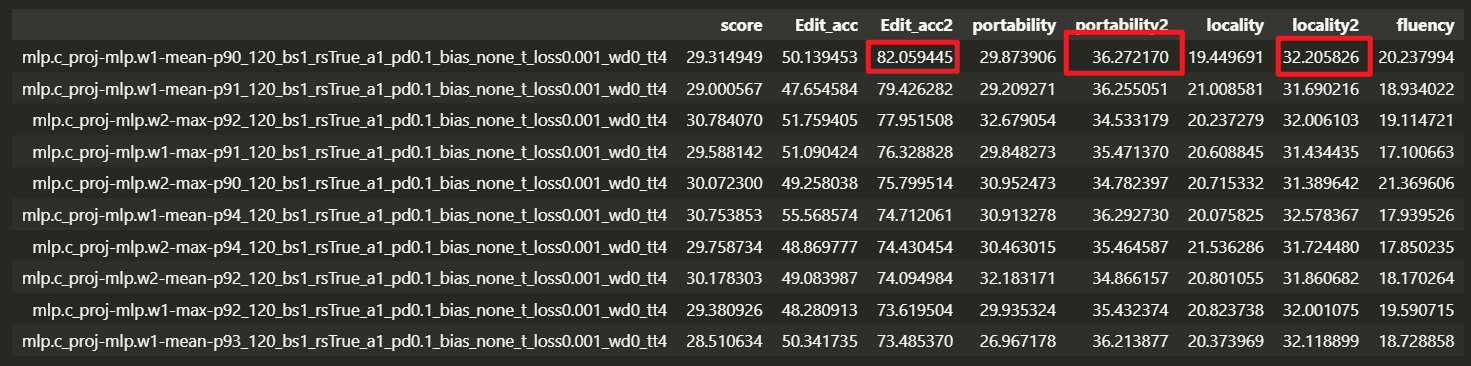

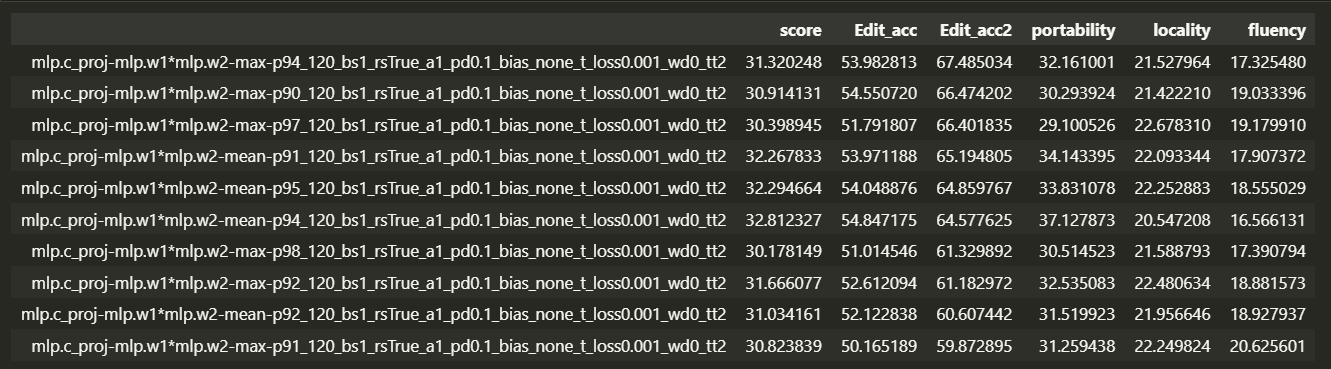

mlp.c_proj-mlp.w1-mean-p90_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.001_wd0_tt4	29.314949	50.139453	82.059445	29.873906	19.449691	20.237994
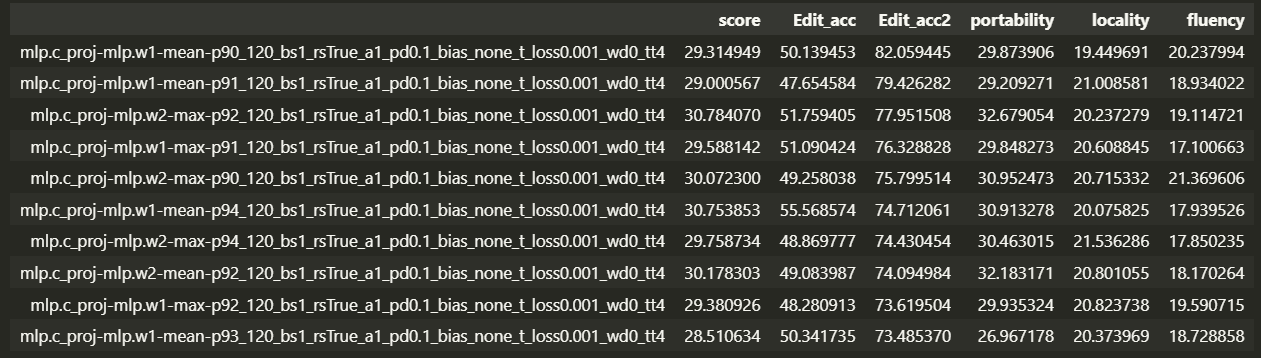

In [ ]:
type = 'type5_70'
root_dir = f'../ccks2024_output_zxy/{type}/log'
metric_dict = {}
file_names = os.listdir(root_dir)
file_names = [file for file in file_names if file.startswith(type)]
print(file_names)
for file in file_names:
    try:
        submit_path = os.path.join(root_dir, file)
        out_path = os.path.join('./metrics_results', file)
        check_format(submit_path)
        score = eval_score(submit_path)
        # print(file)
        result = report_score(score, out_path)
        # type1_133-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-w1*w2-knb_dict-max-p99.5_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4_log
        key = file.replace(f'{type}-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-', '').replace('knb_dict-', '').replace('_log.json', '')
        metric_dict[key] = result['scoreJson']
    except Exception as e:
        print(e)
metric_pd = pd.DataFrame(metric_dict)

In [ ]:
metric_pd.transpose().sort_values(by='Edit_acc', ascending=False)[:10]

In [ ]:
metric_pd.transpose().sort_values(by='Edit_acc2', ascending=False)[:10]

In [ ]:
path = '../ccks2024_output/type5_70/log/type5_70-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-mlp.w1-knb_dict-max-p94_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.001_wd0_tt4_log.json'
with open(path, 'r', encoding='utf-8') as file:
    lines = file.readlines()
    print(f'data size: {len(lines)}')
    data = []
    for line in lines:
        data.append(json.loads(line))

rewrite_answer, rewrite_outputs, rewrite_outputs2 = [], [], []
for item in data:
    rewrite_answer.append(item['requested_rewrite']['target_new'])
    rewrite_outputs.append(item['post']['rewrite_ans'][:len(rewrite_answer[-1])*4])
    rewrite_outputs2.append(item['post']['rewrite_ans'][:len(rewrite_answer[-1])+1])

result_pd = pd.DataFrame({'rewrite_answer': rewrite_answer, 'rewrite_outputs': rewrite_outputs, 'rewrite_outputs2': rewrite_outputs2})
result_pd.to_csv('result.csv', index=False)

In [ ]:
type = 'type7_277'
root_dir = f'../ccks2024_output/{type}/log'
metric_dict = {}
file_names = os.listdir(root_dir)
# file_names = [file for file in file_names if file.startswith(type)]
print(file_names)
for file in file_names:
    try:
        submit_path = os.path.join(root_dir, file)
        out_path = os.path.join('./metrics_results', file)
        check_format(submit_path)
        score = eval_score(submit_path)
        # print(file)
        result = report_score(score, out_path)
        # type1_133-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-w1*w2-knb_dict-max-p99.5_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4_log
        key = file.replace(f'{type}-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-', '').replace('knb_dict-', '').replace('_log.json', '')
        metric_dict[key] = result['scoreJson']
    except Exception as e:
        print(e)
metric_pd = pd.DataFrame(metric_dict)
metric_pd.transpose()

In [ ]:
type = 'type2_80'
root_dir = f'../ccks2024_output_zxy/{type}/log'
metric_dict = {}
file_names = os.listdir(root_dir)
file_names = [file for file in file_names if file.startswith(type)]
print(file_names)
for file in file_names:
    try:
        submit_path = os.path.join(root_dir, file)
        out_path = os.path.join('./metrics_results', file)
        check_format(submit_path)
        score = eval_score(submit_path)
        # print(file)
        result = report_score(score, out_path)
        # type1_133-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-w1*w2-knb_dict-max-p99.5_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4_log
        key = file.replace(f'{type}-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-', '').replace('knb_dict-', '').replace('_log.json', '')
        metric_dict[key] = result['scoreJson']
    except Exception as e:
        print(e)
metric_pd = pd.DataFrame(metric_dict)
metric_pd.transpose()

In [ ]:
type = 'type4_50'
root_dir = f'../ccks2024_output_zxy/{type}/log'
metric_dict = {}
file_names = os.listdir(root_dir)
file_names = [file for file in file_names if file.startswith(type)]
print(file_names)
for file in file_names:
    try:
        submit_path = os.path.join(root_dir, file)
        out_path = os.path.join('./metrics_results', file)
        check_format(submit_path)
        score = eval_score(submit_path)
        # print(file)
        result = report_score(score, out_path)
        # type1_133-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-w1*w2-knb_dict-max-p99.5_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4_log
        key = file.replace(f'{type}-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-', '').replace('knb_dict-', '').replace('_log.json', '')
        metric_dict[key] = result['scoreJson']
    except Exception as e:
        print(e)
metric_pd = pd.DataFrame(metric_dict)
metric_pd.transpose()

mlp.c_proj-w1*w2-max-p99.2_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.001_wd0_tt4	41.673942	70.760710	40.410266	30.251555	27.901626

In [ ]:
type = 'type5_70'
root_dir = f'../ccks2024_output_zxy/{type}/log'
metric_dict = {}
file_names = os.listdir(root_dir)
file_names = [file for file in file_names if file.startswith(type)]
print(file_names)
for file in file_names:
    try:
        submit_path = os.path.join(root_dir, file)
        out_path = os.path.join('./metrics_results', file)
        check_format(submit_path)
        score = eval_score(submit_path)
        # print(file)
        result = report_score(score, out_path)
        # type1_133-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-w1*w2-knb_dict-max-p99.5_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4_log
        key = file.replace(f'{type}-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-', '').replace('knb_dict-', '').replace('_log.json', '')
        metric_dict[key] = result['scoreJson']
    except Exception as e:
        print(e)
metric_pd = pd.DataFrame(metric_dict)
metric_pd.transpose()

In [ ]:
type = 'type6_50'
root_dir = f'../ccks2024_output_zxy/{type}/log'
metric_dict = {}
file_names = os.listdir(root_dir)
file_names = [file for file in file_names if file.startswith(type)]
print(file_names)
for file in file_names:
    try:
        submit_path = os.path.join(root_dir, file)
        out_path = os.path.join('./metrics_results', file)
        check_format(submit_path)
        score = eval_score(submit_path)
        # print(file)
        result = report_score(score, out_path)
        # type1_133-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-w1*w2-knb_dict-max-p99.5_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4_log
        key = file.replace(f'{type}-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-', '').replace('knb_dict-', '').replace('_log.json', '')
        metric_dict[key] = result['scoreJson']
    except Exception as e:
        print(e)
metric_pd = pd.DataFrame(metric_dict)
metric_pd.transpose()

In [ ]:
root_dir = '../ccks2024_output/type1_133/log'
metric_dict = {}
file_names = os.listdir(root_dir)
file_names = [file for file in file_names if file.startswith('type1_133')]
print(file_names)
for file in file_names:
    try:
        submit_path = os.path.join(root_dir, file)
        out_path = os.path.join('./metrics_results', file)
        check_format(submit_path)
        score = eval_score(submit_path)
        # print(file)
        result = report_score(score, out_path)
        # type1_133-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-w1*w2-knb_dict-max-p99.5_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4_log
        key = file.replace('type1_133-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-', '').replace('knb_dict-', '').replace('_log.json', '')
        metric_dict[key] = result['scoreJson']
    except Exception as e:
        print(e)
metric_pd = pd.DataFrame(metric_dict)
metric_pd.transpose()

mlp.c_proj-w1*w2-max-p99.1_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.01_wd0_tt4	23.257763	70.454800	16.394223	0.0	34.288251
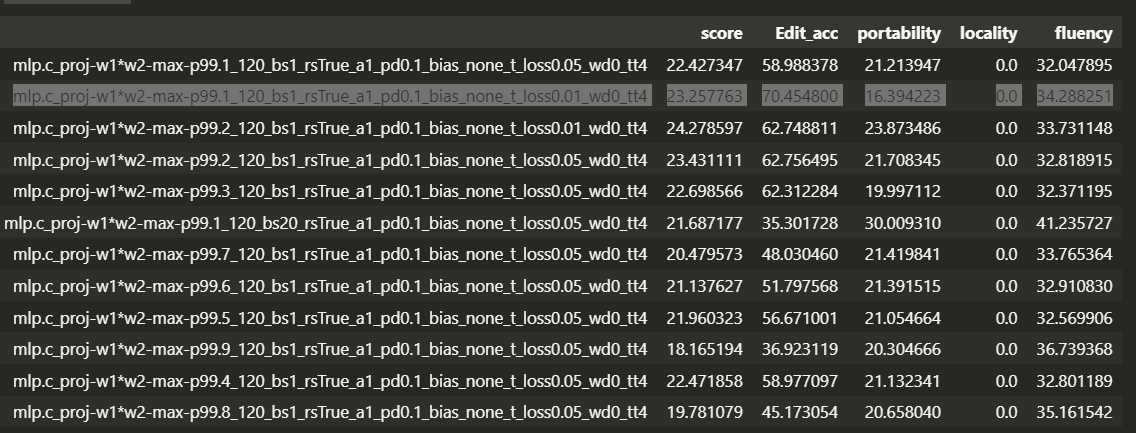

In [ ]:
root_dir = '../ccks2024_output/type3_40/log'
metric_dict = {}
file_names = os.listdir(root_dir)
file_names = [file for file in file_names if file.startswith('type3_40')]
print(file_names)
for file in file_names:
    try:
        submit_path = os.path.join(root_dir, file)
        out_path = os.path.join('./metrics_results', file)
        check_format(submit_path)
        score = eval_score(submit_path)
        print(file)
        result = report_score(score, out_path)
        # type1_133-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-w1*w2-knb_dict-max-p99.5_120_bs1_rsTrue_a1_pd0.1_bias_none_t_loss0.05_wd0_tt4_log
        key = file.replace('type1_133-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-', '').replace('knb_dict-', '').replace('_log.json', '')
        metric_dict[key] = result['scoreJson']
    except Exception as e:
        print(e)
metric_pd = pd.DataFrame(metric_dict)
metric_pd.transpose()

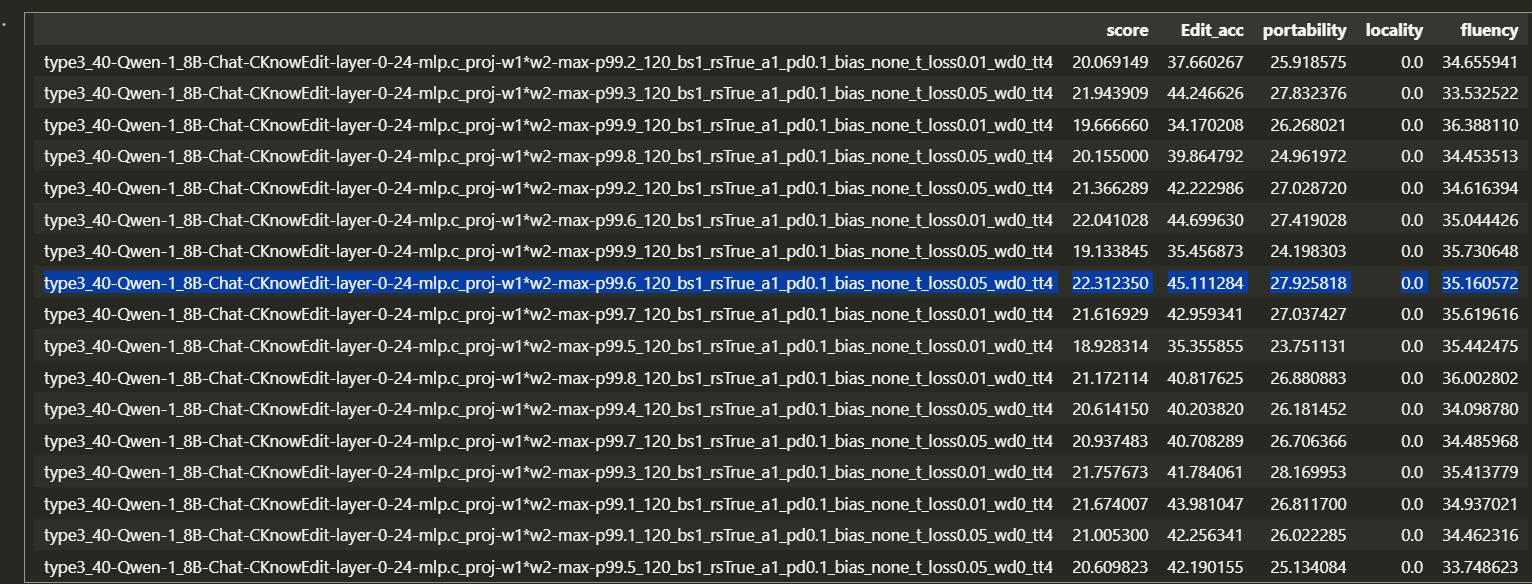

{'score': 27.435813945075687, 'Edit_acc': 35.37228115967342, 'portability': 25.351692807106748, 'locality': 22.471266984939575, 'fluency': 36.233217859247894}
0,70_type5_70-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-knb_dict-mean-bs1_100_p99.05_rsTrue_a1_pd0.1_bias_none_t_loss0.01_wd0_tt2.json

0,70_type5_70-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-knb_dict-mean-bs1_100_p99.35_rsTrue_a1_pd0.1_bias_none_t_loss0.1_wd0_tt4.json
{'Edit_acc': {'BLEU SCORE': 0.018000606663713756, 'ROUGE-1': 0.014285714285714285, 'ROUGE-2': 0.0, 'ROUGE-L': 0.014285714285714285, 'Bert Score': 0.633683443069458, 'final_score': 32.39845786775861}, 'portability': {'BLEU SCORE': 0.0028442105782886216, 'ROUGE-1': 0.0, 'ROUGE-2': 0.0, 'ROUGE-L': 0.0, 'Bert Score': 0.45265546441078186, 'final_score': 22.632773220539093}, 'locality': {'BLEU SCORE': 0.0006666877137198298, 'ROUGE-1': 0.0, 'ROUGE-2': 0.0, 'ROUGE-L': 0.0, 'Bert Score': 0.47480714321136475, 'final_score': 23.740357160568237}, 'fluency': 37.723844043301035}

{'score': 20.610242258505274, 'Edit_acc': 35.02366900444031, 'portability': 26.348072290420532, 'locality': 0, 'fluency': 43.83683155970026}
0,40_type3_40-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-knb_dict-mean-bs1_100_p99.65_rsTrue_a1_pd0.1_bias_none_t_loss0.01_wd0_tt2.json

{'score': 40.22284491820564, 'Edit_acc': 49.98349289099375, 'portability': 36.114828250347045, 'locality': 37.92186390470575, 'fluency': 43.133040857384124}
0,50_type4_50-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-knb_dict-mean-bs1_100_p99.65_rsTrue_a1_pd0.1_bias_none_t_loss0.01_wd0_tt2.json

{'Edit_acc': {'BLEU SCORE': 0.04142679868537507, 'ROUGE-1': 0.02857142857142857, 'ROUGE-2': 0.0, 'ROUGE-L': 0.02857142857142857, 'Bert Score': 0.7325635552406311, 'final_score': 38.056749190602986}, 'portability': {'BLEU SCORE': 0.0009528046358681467, 'ROUGE-1': 0.0, 'ROUGE-2': 0.0, 'ROUGE-L': 0.0, 'Bert Score': 0.48874256014823914, 'final_score': 24.437128007411957}, 'locality': {'BLEU SCORE': 0.0050658566077895545, 'ROUGE-1': 0.0, 'ROUGE-2': 0.0, 'ROUGE-L': 0.0, 'Bert Score': 0.5525553226470947, 'final_score': 27.627766132354736}, 'fluency': 37.969656644401056}
0,70_type5_70-Qwen-1_8B-Chat-CKnowEdit-layer-0-24-mlp.c_proj-knb_dict-mean-bs1_100_p99.35_rsTrue_a1_pd0.1_bias_none_t_loss0.1_wd0.json